# Capstone 3 - Blood Cell Classification - Preprocessing and Modeling - CNN

Previously we loaded the original images into the notebook and transformed them for better edge detection in the modeling portion of the data. We also found that the dataset was very imbalanced. We will be dealing with this problem in this portion of the project with more data augmentation via sheering and cropping of the minor class images. The most important step will be the modeling, where we will create our own convolutional neural network to train and test on the data and also use a pre-trained model. We will lastly compare the performance of the models.

## Loading Data and Images

In [4]:
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, ELU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import math
import random
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16

2025-03-06 12:49:16.045026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
df = pd.read_csv("annotations3.csv")

In [6]:
df.head()

image label
0  transformed_images/image-1.png   wbc
1  transformed_images/image-2.png   wbc
2  transformed_images/image-4.png   wbc
3  transformed_images/image-7.png   wbc
4  transformed_images/image-8.png   wbc

In [7]:
def plot_images(images):
    # Calculate grid size based on number of images
    num_images = len(images)
    grid_size = (math.ceil(num_images / 3), 3)  # 3 columns, adjust rows dynamically

    # Create a grid of subplots
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, grid_size[0] * 3))

    # Flatten axes array for easy iteration (in case it's 2D)
    axes = axes.flatten()

    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.axis('off')  # Hide axis
    
    # Remove any unused axes (if the grid size is larger than the number of images)
    for i in range(len(images), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()  # Adjust layout to ensure images fit nicely
    plt.show()

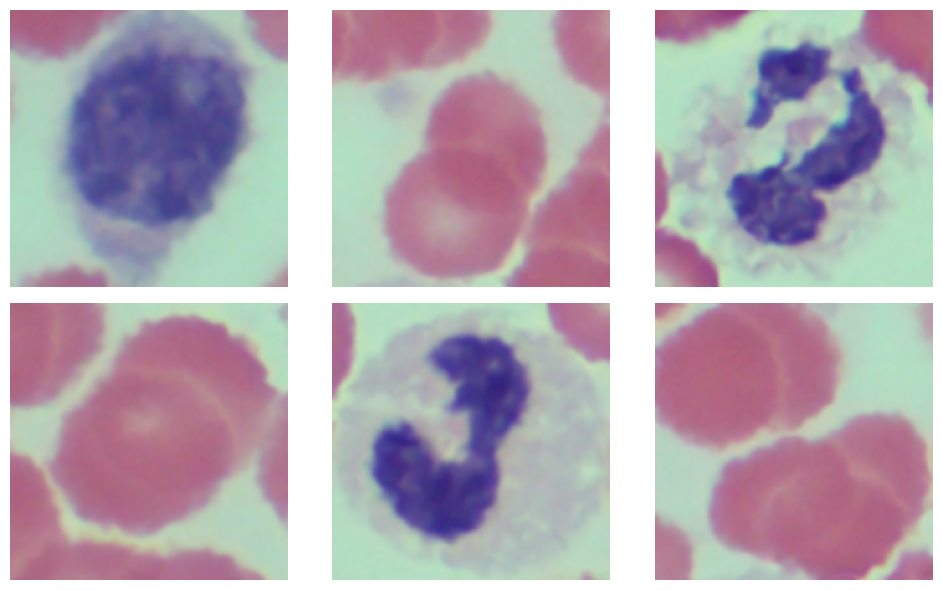

In [8]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[67:73]]
plot_images(get_images)

## Preprocessing

As conveyed below we have a very imbalanced dataset with white blood cells being the minority class. To fix this situation we will perfrom some geometric transformations such as sheering, cropping, etc. on the wbc images to balance the data.

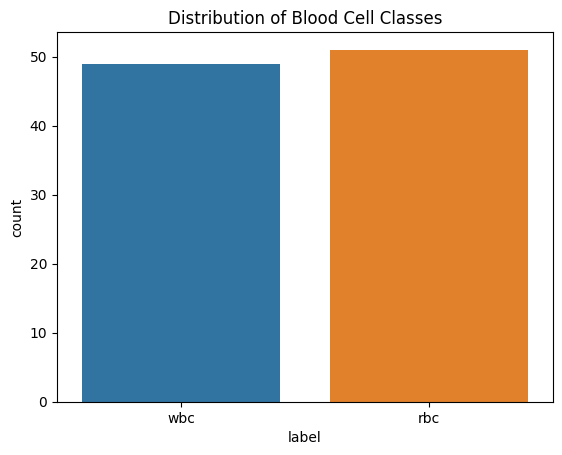

In [11]:
sns.countplot(x='label', data=df) 
plt.title('Distribution of Blood Cell Classes')
plt.show()

In [12]:
df.shape

(100, 2)

In [13]:
df['label'].value_counts()

label
rbc    51
wbc    49
Name: count, dtype: int64

In [14]:
image_path = df.loc[0, 'image']  # Get the file path from the first row
image = Image.open(image_path)

# Get the image shape (width, height)
image_shape = image.size  # Returns (width, height)
print(image_shape)

(224, 224)


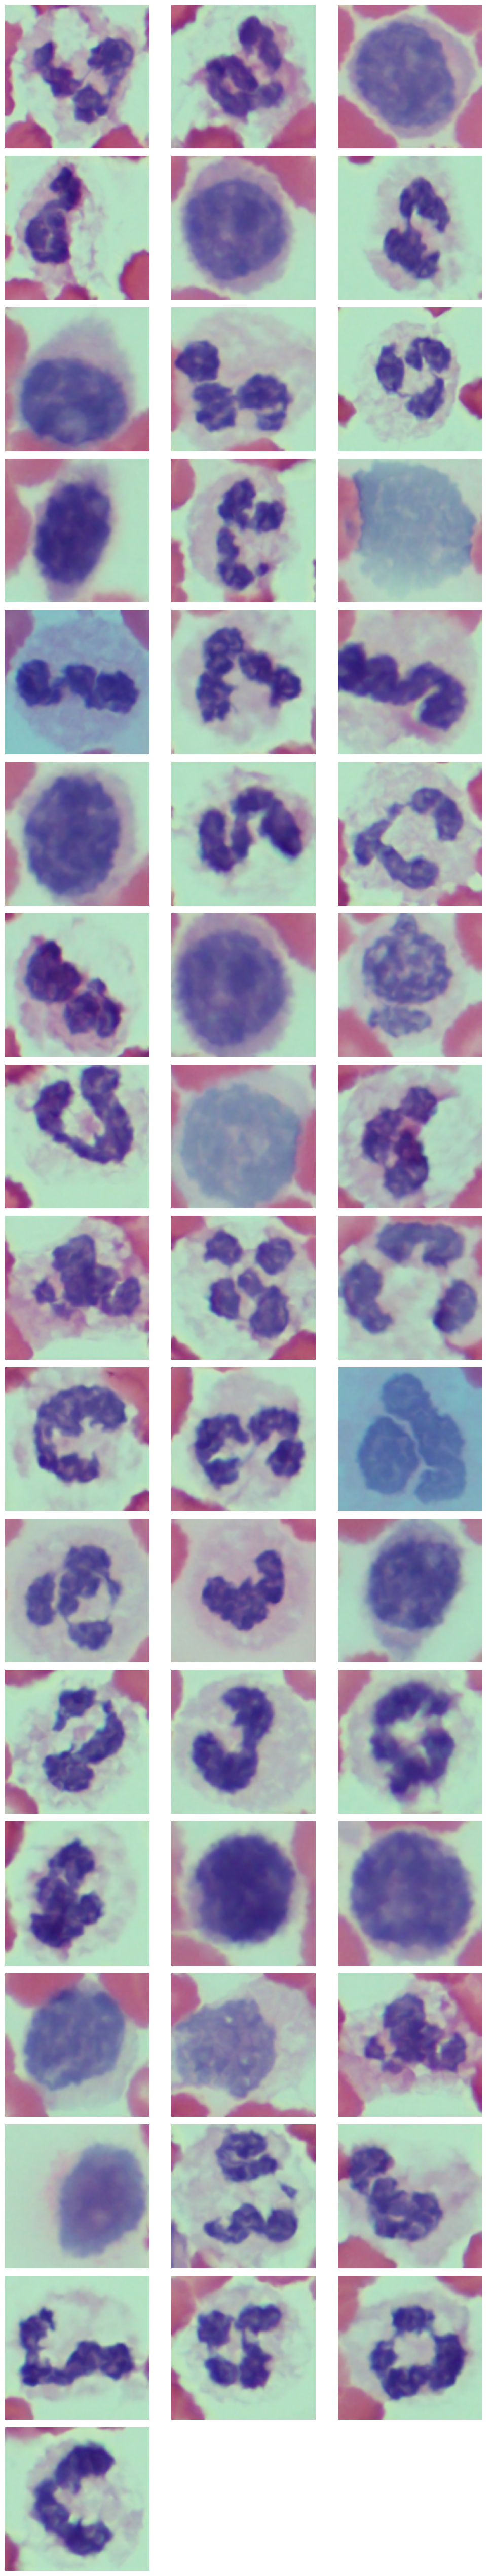

In [15]:
# Filter the DataFrame to find the row(s) with the desired image path
trans_images = df[df['label'].str.contains('wbc', case=False)] 

# Load images into a list of NumPy arrays
get_images = [np.array(Image.open(img_path)) for img_path in trans_images['image']]

# Plot the images in a grid
if get_images:
    plot_images(get_images)
else:
    print("No images found")

In [16]:
df['image_path'] = df['image']

### Flip and append flipped images

In [18]:
def flipped_images(df, output_folder="preprocessed_images"):
    new_df = df.copy() 
    wbc_images = df[df['label'].isin(['wbc', 'rbc'])].copy()
    new_rows = []

    for _, row in wbc_images.iterrows():
        image_path = row['image']  # Ensure correct column name
        image = Image.open(image_path)
        image = np.array(image)  # Convert to NumPy

        # Convert to Tensor and apply transformations manually
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

        # Apply transformations manually
        flipped_image = tf.image.flip_left_right(image_tensor)  # Flip horizontally

        # Convert back to NumPy
        augmented_image = tf.squeeze(flipped_image).numpy().astype(np.uint8)

        image_name = os.path.basename(image_path)  # Get just the filename
        flipped_image_path = os.path.join(output_folder, image_name.replace(".png", "_flipped.png"))
        Image.fromarray(augmented_image).save(flipped_image_path)

        # Append new row with flipped image path (keeping all columns)
        new_row = row.copy()
        new_row['image_path'] = flipped_image_path  # Update image path
        new_rows.append(new_row)

    new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True)                              
    return new_df

In [19]:
df = flipped_images(df)

In [20]:
df['label'].value_counts()

label
rbc    102
wbc     98
Name: count, dtype: int64

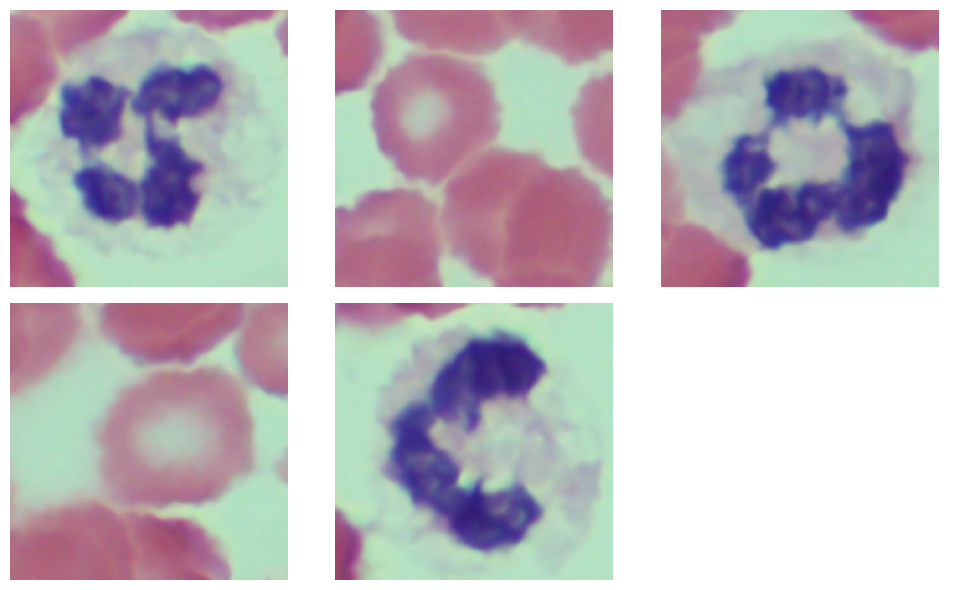

In [21]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[195:]]
plot_images(get_images)

In [22]:
df.tail()

image label  \
195  transformed_images/image-116.png   wbc   
196  transformed_images/image-117.png   rbc   
197  transformed_images/image-118.png   wbc   
198  transformed_images/image-119.png   rbc   
199  transformed_images/image-120.png   wbc   

                                    image_path  
195  preprocessed_images/image-116_flipped.png  
196  preprocessed_images/image-117_flipped.png  
197  preprocessed_images/image-118_flipped.png  
198  preprocessed_images/image-119_flipped.png  
199  preprocessed_images/image-120_flipped.png

### Applying random brightness and appending images

In [24]:
def random_brightness_images(df, output_folder="preprocessed_images"):
    new_df = df.copy() 
    wbc_images = df[df['label'].isin(['wbc', 'rbc'])].copy()
    new_rows = []

    for _, row in wbc_images.iterrows():
        image_path = row['image']  # Ensure correct column name
        image = Image.open(image_path)
        image = np.array(image)  # Convert to NumPy

        # Convert to Tensor and apply transformations manually
        image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)
        image_tensor = tf.expand_dims(image_tensor, axis=0)  # Add batch dimension

        # Apply transformations manually
        seed = (np.random.randint(0, 1000), np.random.randint(0, 1000))
        stateless_random_brightness = tf.image.stateless_random_brightness(
        image_tensor, max_delta=0.8, seed=seed)

        # Convert back to NumPy
        augmented_image = tf.squeeze(stateless_random_brightness).numpy().astype(np.uint8)

        image_name = os.path.basename(image_path)  # Get just the filename
        brightness_image_path = os.path.join(output_folder, image_name.replace(".png", "_bright.png"))
        Image.fromarray(augmented_image).save(brightness_image_path)

        new_row = row.copy()
        new_row['image_path'] = brightness_image_path  # Update image path
        new_rows.append(new_row)

    new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True)                              
    return new_df

In [25]:
df = random_brightness_images(df)

In [26]:
df['label'].value_counts()

label
rbc    204
wbc    196
Name: count, dtype: int64

In [27]:
df.tail()

image label  \
395  transformed_images/image-116.png   wbc   
396  transformed_images/image-117.png   rbc   
397  transformed_images/image-118.png   wbc   
398  transformed_images/image-119.png   rbc   
399  transformed_images/image-120.png   wbc   

                                   image_path  
395  preprocessed_images/image-116_bright.png  
396  preprocessed_images/image-117_bright.png  
397  preprocessed_images/image-118_bright.png  
398  preprocessed_images/image-119_bright.png  
399  preprocessed_images/image-120_bright.png

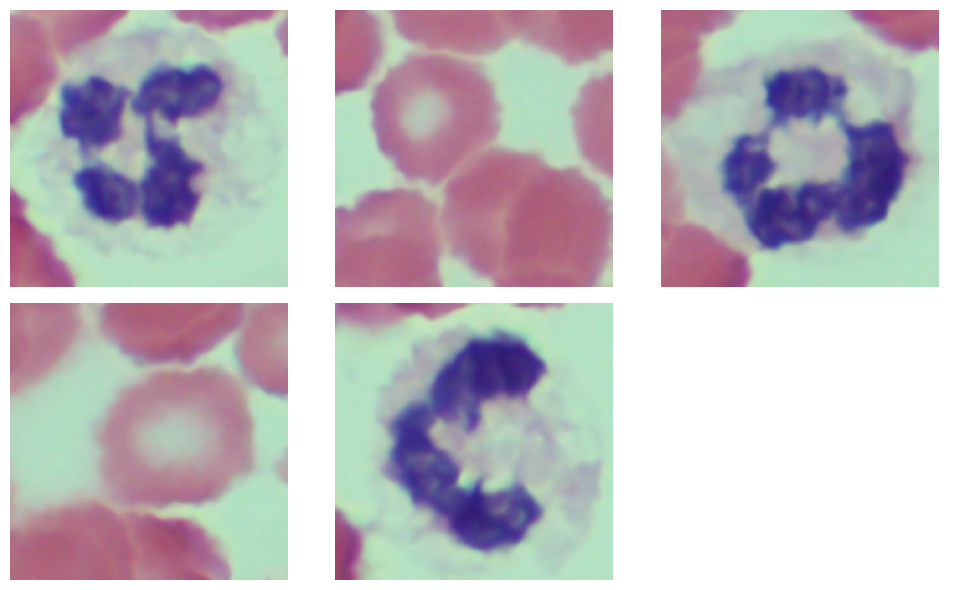

In [28]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[395:]]
plot_images(get_images)

### Rotation and appending images

In [30]:
def rotated_images(df, output_folder="preprocessed_images"):
    new_df = df.copy() 
    wbc_images = df[df['label'].isin(['wbc', 'rbc'])].copy()
    new_rows = []

    for _, row in wbc_images.iterrows():
        image_path = row['image']  # Ensure correct column name
        image = Image.open(image_path)

        # Rotate the image using PIL
        rotated_image = image.transpose(Image.ROTATE_90)
        
        image_name = os.path.basename(image_path)  # Get just the filename
        rotated_image_path = os.path.join(output_folder, image_name.replace(".png", "_rotated.png"))
        rotated_image.save(rotated_image_path)

        new_row = row.copy()
        new_row['image_path'] = rotated_image_path  # Update image path
        new_rows.append(new_row)

    new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True)                              
    return new_df

In [31]:
df = rotated_images(df)

In [32]:
df['label'].value_counts()

label
rbc    408
wbc    392
Name: count, dtype: int64

In [33]:
df.tail()

image label  \
795  transformed_images/image-116.png   wbc   
796  transformed_images/image-117.png   rbc   
797  transformed_images/image-118.png   wbc   
798  transformed_images/image-119.png   rbc   
799  transformed_images/image-120.png   wbc   

                                    image_path  
795  preprocessed_images/image-116_rotated.png  
796  preprocessed_images/image-117_rotated.png  
797  preprocessed_images/image-118_rotated.png  
798  preprocessed_images/image-119_rotated.png  
799  preprocessed_images/image-120_rotated.png

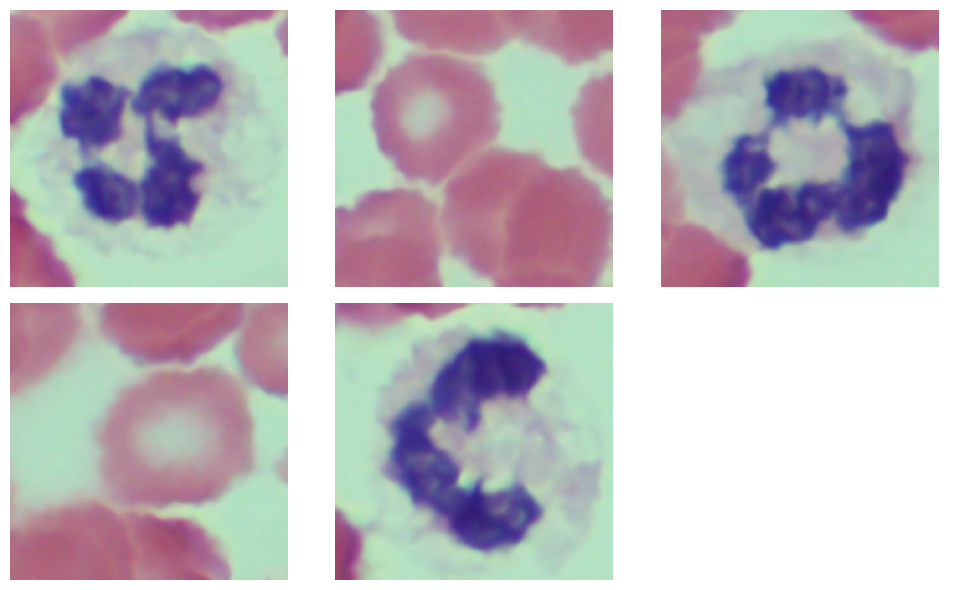

In [34]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[795:]]
plot_images(get_images)

### Crop and append images

In [36]:
def cropped_images(df, output_folder="preprocessed_images"):
    os.makedirs(output_folder, exist_ok=True)

    new_df = df.copy()
    wbc_images = df[df['label'].isin(['wbc', 'rbc'])].copy()
    new_rows = []

    for _, row in wbc_images.iterrows():
        image_path = row['image']
        image = Image.open(image_path)

        # Convert image to NumPy array
        image_array = np.array(image)
        height, width = image_array.shape[:2]  # Keep original dimensions

        # Define crop size (50% center crop)
        crop_fraction = 0.5
        crop_h = int(height * crop_fraction)
        crop_w = int(width * crop_fraction)
        start_h = (height - crop_h) // 2
        start_w = (width - crop_w) // 2

        # Crop the image manually using slicing
        cropped_array = image_array[start_h:start_h + crop_h, start_w:start_w + crop_w]

        # Convert back to PIL Image
        cropped_pil_image = Image.fromarray(cropped_array)

        # Save the cropped image
        image_name = os.path.basename(image_path)
        cropped_image_path = os.path.join(output_folder, image_name.replace(".png", "_crop.png"))
        cropped_pil_image.save(cropped_image_path)

        # Append new row with updated image path
        new_row = row.copy()
        new_row['image_path'] = cropped_image_path  # Update image path
        new_rows.append(new_row)

    # Add new images to dataframe
    new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True)
    return new_df

In [37]:
df = cropped_images(df)

In [38]:
df['label'].value_counts()

label
rbc    816
wbc    784
Name: count, dtype: int64

In [39]:
df.tail()

image label  \
1595  transformed_images/image-116.png   wbc   
1596  transformed_images/image-117.png   rbc   
1597  transformed_images/image-118.png   wbc   
1598  transformed_images/image-119.png   rbc   
1599  transformed_images/image-120.png   wbc   

                                  image_path  
1595  preprocessed_images/image-116_crop.png  
1596  preprocessed_images/image-117_crop.png  
1597  preprocessed_images/image-118_crop.png  
1598  preprocessed_images/image-119_crop.png  
1599  preprocessed_images/image-120_crop.png

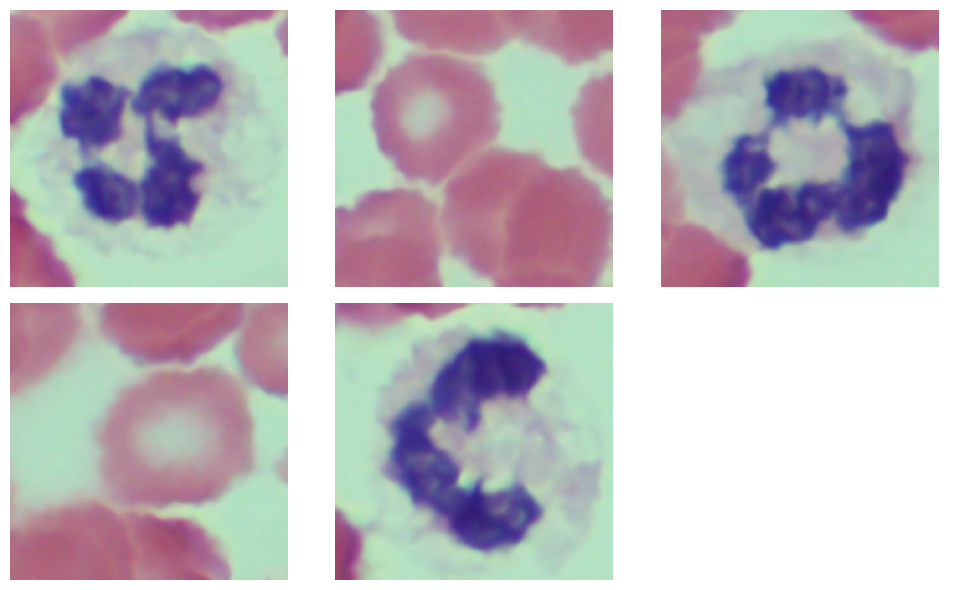

In [40]:
get_images = [np.array(Image.open(img_path)) for img_path in df.image[1595:]]
plot_images(get_images)

Now that we have flipped, cropped, rotated, and adjusted brightness for the white blood cell class to create a more robust dataset and allow for the model to be more robust by learning a diverse set of images. Now we will build the model. We will build a custom one and then compare the performance to a pre-trained model.

## Modeling - CNN from scratch

In [43]:
df.head()

image label                      image_path
0  transformed_images/image-1.png   wbc  transformed_images/image-1.png
1  transformed_images/image-2.png   wbc  transformed_images/image-2.png
2  transformed_images/image-4.png   wbc  transformed_images/image-4.png
3  transformed_images/image-7.png   wbc  transformed_images/image-7.png
4  transformed_images/image-8.png   wbc  transformed_images/image-8.png

In [44]:
# Encode string labels to integer labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Display the mapping of encoded labels
print("Label mapping:", dict(enumerate(label_encoder.classes_)))  

# Use the encoded labels as the target variable
y = df['label_encoded'].values

print("Shape of y:", y.shape)  # Should be (num_samples,)
print(y[:10])  # Preview first 10 labels

Label mapping: {0: 'rbc', 1: 'wbc'}
Shape of y: (1600,)
[1 1 1 1 1 0 0 0 0 1]


In [45]:
def normalize_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Keep RGB channels
    image = image.resize((224, 224))  # Resize to ensure consistency
    image = np.array(image)  # Convert to numpy array
    
    # Normalize the image by scaling pixel values to [0, 1]
    image = image.astype("float32") / 255.0
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    return image_tensor

x = [normalize_image(path) for path in df['image_path']]
# Print the shape of one of the tensors to debug
print(f"Shape of one image: {x[0].shape}")

# Use tf.stack to stack the tensors into a single tensor
X = np.array([image.numpy() for image in x])  # Convert from TensorFlow tensor to NumPy array

# Print the shape of X
print(f"Shape of X: {X.shape}")

Shape of one image: (224, 224, 3)
Shape of X: (1600, 224, 224, 3)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Now it is time to build the custom model. Originally we had many issues with the model only being able to classify one class, which we can infer was due to exploding or vanishing gradient, so we took many proactive measures to prevent underfitting. That is why in our model we use the ELU activation function, which assists in improving the stability of the backpropagation process and avoiding vanishing gradients. This led to a smoother gradient and faster training convergence. We also increase the filter size in each convolutional layer to detect more complex patterns based on previous layers. Then we use MaxPool2D to reduce spatial size and keep important features while lowering computation. Lastly, we use the sigmoid activation function to output a probability of 0-1 for binary classification. 

Now time for choice of optimizer, we started off with Adam but then realized that the loss landscape for the model is too complex for a simple optimizer. Therefore we went for the RMSprop which adjusts the learning rate individually for each parameter, leading to more stable convergence and more robustness. It also works well with ELU activation. Within the optimizer we also chose a starting learning rate of 0.01, which decreases gradually while monitoring the validation loss with the ReduceLROnPlateau() function. We also decided to include momentum to speed up convergence and create more stable training. Lastly in the optimizer we included gradient clipping to further prevent the problem of exploding gradients by limiting the maximum gradient value. Since our model originally was very unstable we took many steps and additions to prevent the instability and promote faster and smoother training.

Along with the decreasing learning rate we also implemented early stopping to prevent overfitting by stopping training when the model's performance on a validation set starts to degrade. Both of these functions were implemented into the fitting of the model, which consisted of 20 epochs, a small batch size of 32 which has a large effect on the model, if doubled then it takes much longer to converge, and lastly a validation split of 0.2. These were the optimal parameters that were found for this dataset and model.

In [48]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(224, 224, 3)),
    ELU(alpha=1.0),  
    MaxPool2D((2, 2)),
    Conv2D(64, (3, 3)),
    ELU(alpha=1.0),  
    MaxPool2D((2, 2)),
    Flatten(),
    Dense(128),
    ELU(alpha=1.0),  
    Dense(1, activation='sigmoid')
])

/Users/lupecovarrubias/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.01, momentum=0.8, clipvalue=0.5)

In [50]:
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [52]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

In [53]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 31s 966ms/step - accuracy: 0.4943 - loss: 213735.9375 - val_accuracy: 0.5042 - val_loss: 138004.7969 - learning_rate: 0.0100
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 942ms/step - accuracy: 0.5217 - loss: 89919.3047 - val_accuracy: 0.5042 - val_loss: 48307.1328 - learning_rate: 0.0100
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 28s 934ms/step - accuracy: 0.5130 - loss: 36541.1562 - val_accuracy: 0.5042 - val_loss: 19710.4941 - learning_rate: 0.0100
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4737 - loss: 94096.0234 - val_accuracy: 0.7125 - val_loss: 5968.0000 - learning_rate: 0.0100
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6220 - loss: 35676.3359 - val_accuracy: 0.5042 - val_loss: 67496.0703 - learning_rate: 0.0100
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 26s 874ms/step - accuracy: 0.5725 - loss: 34281.5234 - val_accuracy: 0.7042 - val_loss: 4514.4497 - learning_rate: 0.0100
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 26

In [54]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

    accuracy           loss  val_accuracy       val_loss  learning_rate
0   0.492708  226502.968750      0.504167  138004.796875          0.010
1   0.503125   84020.648438      0.504167   48307.132812          0.010
2   0.516667   40747.082031      0.504167   19710.494141          0.010
3   0.495833  117226.171875      0.712500    5968.000000          0.010
4   0.660417   34661.097656      0.504167   67496.070312          0.010
5   0.603125   25901.908203      0.704167    4514.449707          0.010
6   0.617708   38677.019531      0.920833     750.057983          0.010
7   0.760417   14257.049805      0.504167   40575.394531          0.010
8   0.759375   29312.302734      0.816667   13216.428711          0.010
9   0.842708   35686.601562      0.954167    1062.644775          0.010
10  0.819792   26444.193359      0.925000    3585.712402          0.010
11  0.912500    4259.498535      0.933333    1994.550781          0.002
12  0.975000    1132.996460      0.954167    3489.016113        

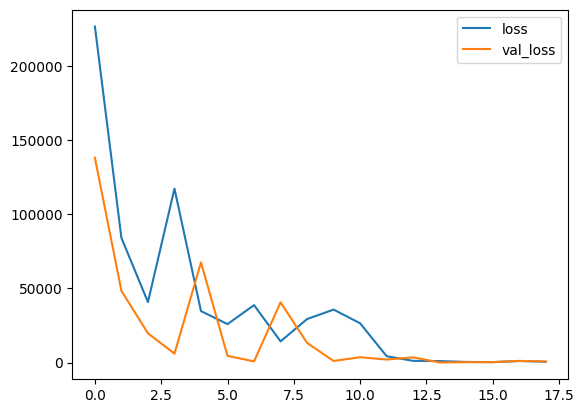

In [55]:
metrics_df[["loss","val_loss"]].plot();

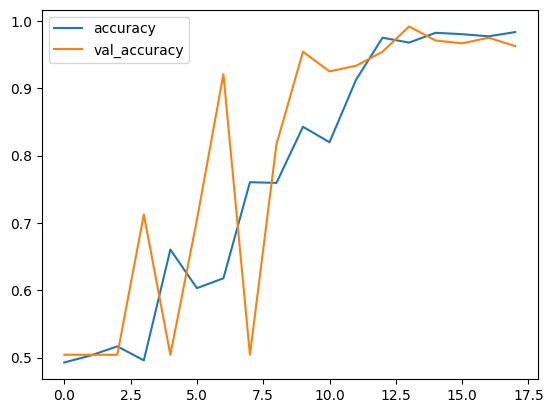

In [56]:
metrics_df[["accuracy","val_accuracy"]].plot();

In [57]:
# Make predictions on the test set
y_pred = (model.predict(X_test) > 0.5).astype("int32") 

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Alternatively, use classification_report for more detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step
Precision: 0.9855072463768116
Recall: 1.0
F1-score: 0.9927007299270073
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       196
           1       0.99      1.00      0.99       204

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



Our model performs very well. Nearly perfect precision and recall for both classes and a great f-1 score. The main thing we can see here is that the model had a high training accuracy at about 9 epochs and high validation accuracy at abourabout epoch 6 and then continues to improve. Now let's compare our model to a pre-trained model. 

### Pretrained Model with VGG16

In [60]:
# Load pre-trained VGG16 without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
base_model.trainable = False

In [61]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

In [62]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

In [63]:
# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.5381 - loss: 1.4815 - val_accuracy: 0.7833 - val_loss: 0.4558
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 158s 5s/step - accuracy: 0.8275 - loss: 0.4462 - val_accuracy: 0.8667 - val_loss: 0.3462
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 155s 5s/step - accuracy: 0.8954 - loss: 0.3140 - val_accuracy: 0.8958 - val_loss: 0.2305
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.9495 - loss: 0.1964 - val_accuracy: 1.0000 - val_loss: 0.1352
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.9943 - loss: 0.1182 - val_accuracy: 0.9750 - val_loss: 0.1275
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.9810 - loss: 0.1038 - val_accuracy: 1.0000 - val_loss: 0.0608
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 146s 5s/step - accuracy: 0.9987 - loss: 0.0510 - val_accuracy: 1.0000 - val_loss: 0.0469
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 145s 5s/step - accuracy: 1.0000 - loss: 0.0439 - val_accuracy: 1.0000 - v

In [65]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

   accuracy      loss  val_accuracy  val_loss
0  0.591667  0.934067      0.783333  0.455839
1  0.834375  0.413952      0.866667  0.346232
2  0.921875  0.276969      0.895833  0.230463
3  0.963542  0.175246      1.000000  0.135188
4  0.991667  0.111680      0.975000  0.127498
5  0.984375  0.088192      1.000000  0.060770
6  0.998958  0.053108      1.000000  0.046855
7  1.000000  0.039557      1.000000  0.036235


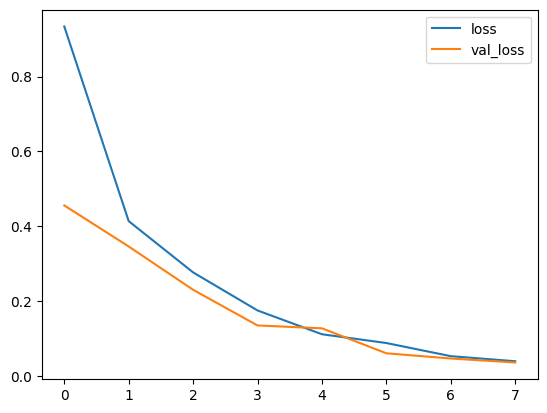

In [66]:
metrics_df[["loss","val_loss"]].plot();

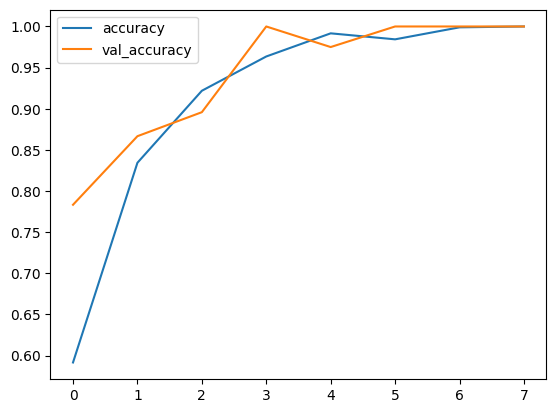

In [67]:
metrics_df[["accuracy","val_accuracy"]].plot();

In [68]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert to binary predictions
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 52s 4s/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       196
           1       0.99      1.00      0.99       204

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



This model performed very well. Nearly perfect precision and recall for both classes and a great f-1 score. The main difference between this model and the previous is that it learns significantly faster, achieving higher accuracy within the first few epochs, as well as smoother and more consistent decrease in loss. This seems consistent with the fact that it is a pre-trained model.

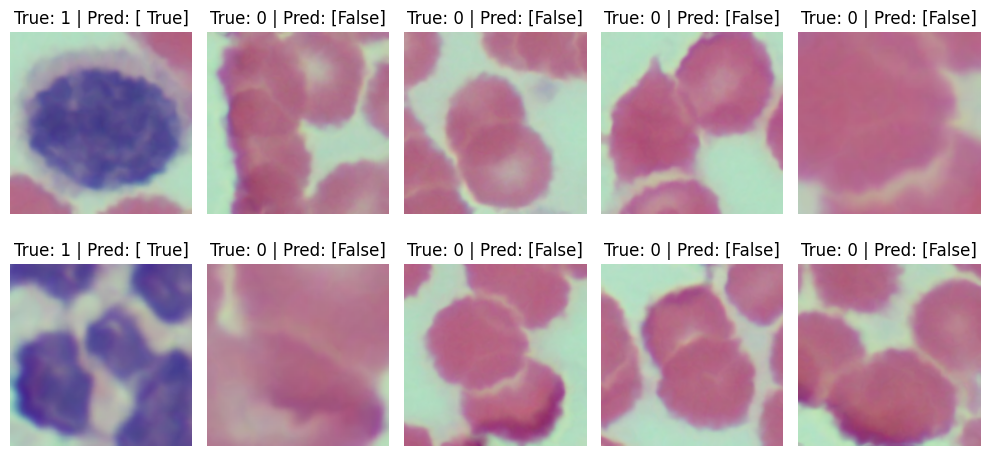

In [130]:
def plot_predictions(images, y_true, y_pred, num_samples=10):
    plt.figure(figsize=(10, 5))
    
    for i in range(num_samples):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])  # Show the image
        plt.title(f"True: {y_true[i]} | Pred: {y_pred[i]}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

# Call function with some test images
plot_predictions(X_test[:10], y_test[:10], y_pred[:10])

## Conclusion

Overall both models are excellent and demonstrate exceptional performance. Both have strong generalization with high accuracy. Although, our model is an excellent candidate, the pre-trained model significantly accelerates learning, improves generalization, and leads to better overall performance. Based on the provided metrics, the pre-trained model appears to be the superior choice in most scenarios. Its faster training, higher accuracy, and excellent generalization make it a strong performer. However, if we have specific requirements for task specificity and control the custom model might be a viable alternative.

In [ ]:
model.save("blood_cell_classification)")  # Saves the model in TensorFlow's native format